In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Terzaghi 1D consolidation analytical solution

In [2]:
# Fourier series solution
def anasol_drained(z, t, H, cv, p0, k_terms):
    p = 0
    for k in range(1, k_terms+1):
        term = (-1)**(k-1)/(2*k-1)
        cos = np.cos((2*k-1)*np.pi*z/(H))
        exp = np.exp(-(2*k-1)**2*np.pi**2*cv*t/(H**2))                   
        p += term*cos*exp
    p = p*4/np.pi
    return p


In [3]:
t = 1.0  # time in days
z = 1.0  # depth in meters
delta_sigma = 100  # applied vertical stress increment in kPa
k = 2e-4  # coefficient of permeability in m/s
mv = 1/1800  # coefficient of volume compressibility in m²/N
H = 10.0  # thickness of soil layer in meters
terms = 100  # number of terms in the Fourier series

cv = k/(mv*9.81)  # consolidation coefficient in m²/s

In [4]:
anasol_drained(z, 365, H, cv, delta_sigma, terms)

0.32283746660179835

# Defining the PINN

In [5]:
class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN), 
                        activation()])

        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN), 
                            activation()]) for _ in range(N_LAYERS-1)])

        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        # Glorot weight initialization
        for layer in self.fcs:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
        for layer in self.fch:
            for sublayer in layer:
                if isinstance(sublayer, nn.Linear):
                    nn.init.xavier_uniform_(sublayer.weight)
        nn.init.xavier_uniform_(self.fce.weight)
        

    def forward(self, x):
        # feature min-max scaling
        x = (x - l_b)/(u_b - l_b)

        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x


## Defining parameters, creating training data

In [6]:
# Parameters
H = 1.0  # Height of the soil column in meters
cv_obs = 0.1  # Coefficient of consolidation 
p0 = 1.0  # Initial pressure
n_terms = 2000  # Number of Fourier terms
n_z = 500  # Number of spatial points
n_t = 100  # Number of time points
n_data = 1000  # Number of data points
n_colloc = 2000
n_ic = 100
n_bc = 100
t_min = 0.001

z = np.linspace(-H/2, H/2, n_z)
t = np.linspace(t_min, 1.0, n_t)

Z, T = np.meshgrid(z, t)

z_flat = Z.flatten()
t_flat = T.flatten()

# we should have the same data for all the time points
def create_data(n_data, t_min, noise):
    zt_data = torch.rand(n_data, 2)
    zt_data[:, 1] = zt_data[:, 1]*(1-t_min)+t_min
    zt_data[:, 0] = zt_data[:, 0]*H - H/2  # Adjust z to be in the range [-0.5, 0.5]
    zt_data = torch.tensor(zt_data, dtype=torch.float32)
    u_data = torch.tensor([anasol_drained(z, t, H, cv_obs, p0, n_terms) + noise* np.random.randn() for z, t in zt_data.detach().numpy()], dtype=torch.float32)
    u_data = u_data.view(-1, 1)
    return zt_data, u_data


def create_colloc(n_colloc, t_min):
    np.random.seed(seed)
    zt_colloc = lhs(2, samples=n_colloc)
    zt_colloc[:, 1] = zt_colloc[:,1]*(1-t_min)+t_min
    zt_colloc[:, 0] = zt_colloc[:, 0]*H - H/2  # Adjust z to be in the range [-0.5, 0.5]

    z_colloc = torch.tensor(zt_colloc[:, 0], dtype=torch.float32).requires_grad_(True)
    t_colloc = torch.tensor(zt_colloc[:, 1], dtype=torch.float32).requires_grad_(True)
    return z_colloc, t_colloc


def create_ic(n_ic, t_min):
    np.random.seed(seed)
    zt_ic = torch.tensor([ lhs(1, samples=n_ic).squeeze()*H-H/2, np.ones(n_ic)*t_min ], dtype=torch.float32).T
    u_ic = torch.tensor([anasol_drained(z, t_min, H, cv_obs, p0, n_terms) for z in zt_ic[:, 0].detach().numpy()], dtype=torch.float32)
    u_ic = u_ic.view(-1, 1)
    return zt_ic, u_ic

def create_bc(n_bc, t_min):
    np.random.seed(seed)
    zt_bc1 = torch.tensor([ np.ones(n_bc) * -H/2, lhs(1, samples=n_bc).squeeze()*(1-t_min)+t_min ], dtype=torch.float32).T
    zt_bc2 = torch.tensor([ np.ones(n_bc) * H/2, lhs(1, samples=n_bc).squeeze()*(1-t_min)+t_min ], dtype=torch.float32).T
    zt_bc = torch.cat([zt_bc1, zt_bc2], dim=0)
    return zt_bc



zt_data, u_data = create_data(n_data, t_min, 0.0)
zt_data_noisy, u_data_noisy = create_data(n_data, t_min, 0.05)
z_colloc, t_colloc = create_colloc(n_colloc, t_min)
zt_colloc = torch.cat([z_colloc.unsqueeze(1), t_colloc.unsqueeze(1)], dim=1)
zt_ic, u_ic = create_ic(n_ic, t_min)
zt_bc, u_bc = create_bc(n_bc, t_min), torch.zeros(2*n_bc, dtype=torch.float32)
Z_test, T_test = torch.from_numpy(Z).float(), torch.from_numpy(T).float()
zt_test = torch.cat([Z_test.flatten().unsqueeze(1), T_test.flatten().unsqueeze(1)], dim=1)

# Compute the analytical solution for each pair
U = np.array([anasol_drained(z, ts, H, cv_obs, p0, n_terms) for ts in t]) #t values

C:\Users\jolu2\AppData\Local\Temp\ipykernel_29156\1230174516.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zt_data = torch.tensor(zt_data, dtype=torch.float32)
C:\Users\jolu2\AppData\Local\Temp\ipykernel_29156\1230174516.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  zt_ic = torch.tensor([ lhs(1, samples=n_ic).squeeze()*H-H/2, np.ones(n_ic)*t_min ], dtype=torch.float32).T


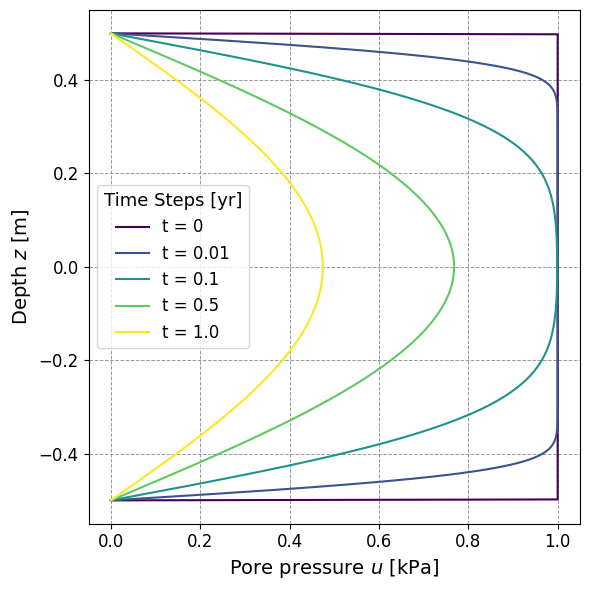

In [7]:
from matplotlib.cm import viridis
U_init = np.array([0] + [1]*(n_z-2) + [0])

# Create a publication-ready plot with updated color scheme, style, and grid included
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
colors = viridis(np.linspace(0, 1, 5))
# Plot the curves with updated colors and line styles
ax.plot(U_init, z, label='t = 0',  color=colors[0], linewidth=1.5)
ax.plot(U[1], z, label='t = 0.01', color=colors[1], linewidth=1.5)
ax.plot(U[10], z, label='t = 0.1', color=colors[2], linewidth=1.5)
ax.plot(U[50], z, label='t = 0.5', color=colors[3], linewidth=1.5)
ax.plot(U[99], z, label='t = 1.0', color=colors[4], linewidth=1.5)

# Customize grid, axis labels, and legend for publication
ax.set_xlabel('Pore pressure $u$ [kPa]', fontsize=14)
ax.set_ylabel('Depth $z$ [m]', fontsize=14)
ax.grid(visible=True, linestyle='--', linewidth=0.7, color='gray', alpha=0.8)  # Add grid

# Add legend
ax.legend(title='Time Steps [yr]', fontsize=12, title_fontsize=13, loc='center left', frameon=True)

# Add tick marks and set font sizes
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)

# Adjust layout
plt.tight_layout()
# plt.savefig('analytical_sol.png')
# Show the plot
plt.show()



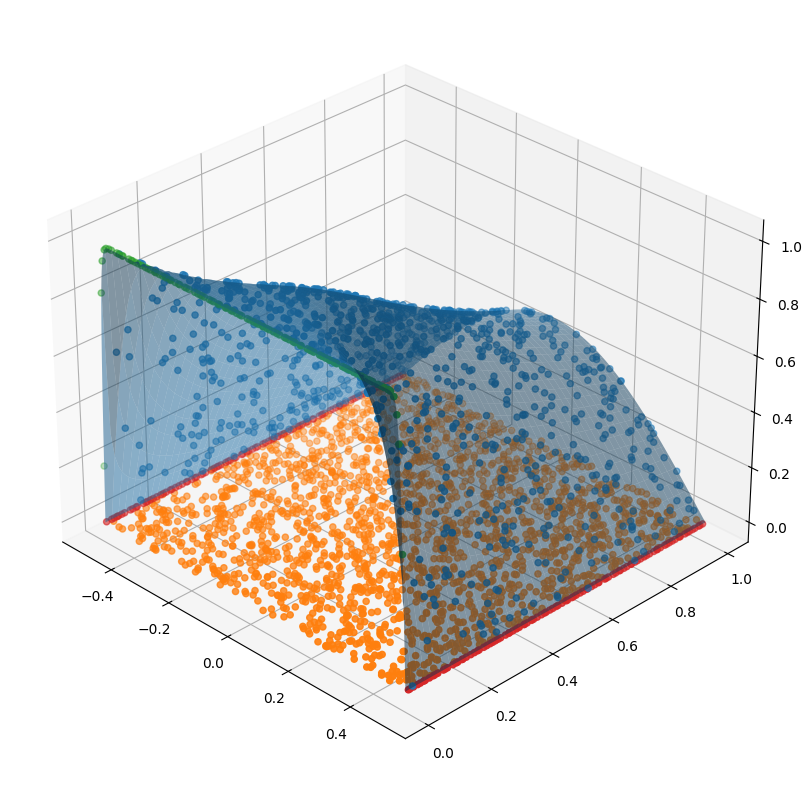

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zt_data[:, 0].detach().numpy(), zt_data[:, 1].detach().numpy(), u_data[:, 0].detach().numpy())
ax.scatter(zt_colloc[:, 0].detach().numpy(), zt_colloc[:, 1].detach().numpy(), np.zeros(n_colloc))
ax.scatter(zt_ic[:, 0].detach().numpy(), zt_ic[:, 1].detach().numpy(), u_ic[:,0].detach().numpy())
ax.scatter(zt_bc[:, 0].detach().numpy(), zt_bc[:, 1].detach().numpy(), np.zeros(2*n_bc))
ax.plot_surface(Z, T, U, alpha=0.5)
ax.view_init(30, -45)
plt.show()

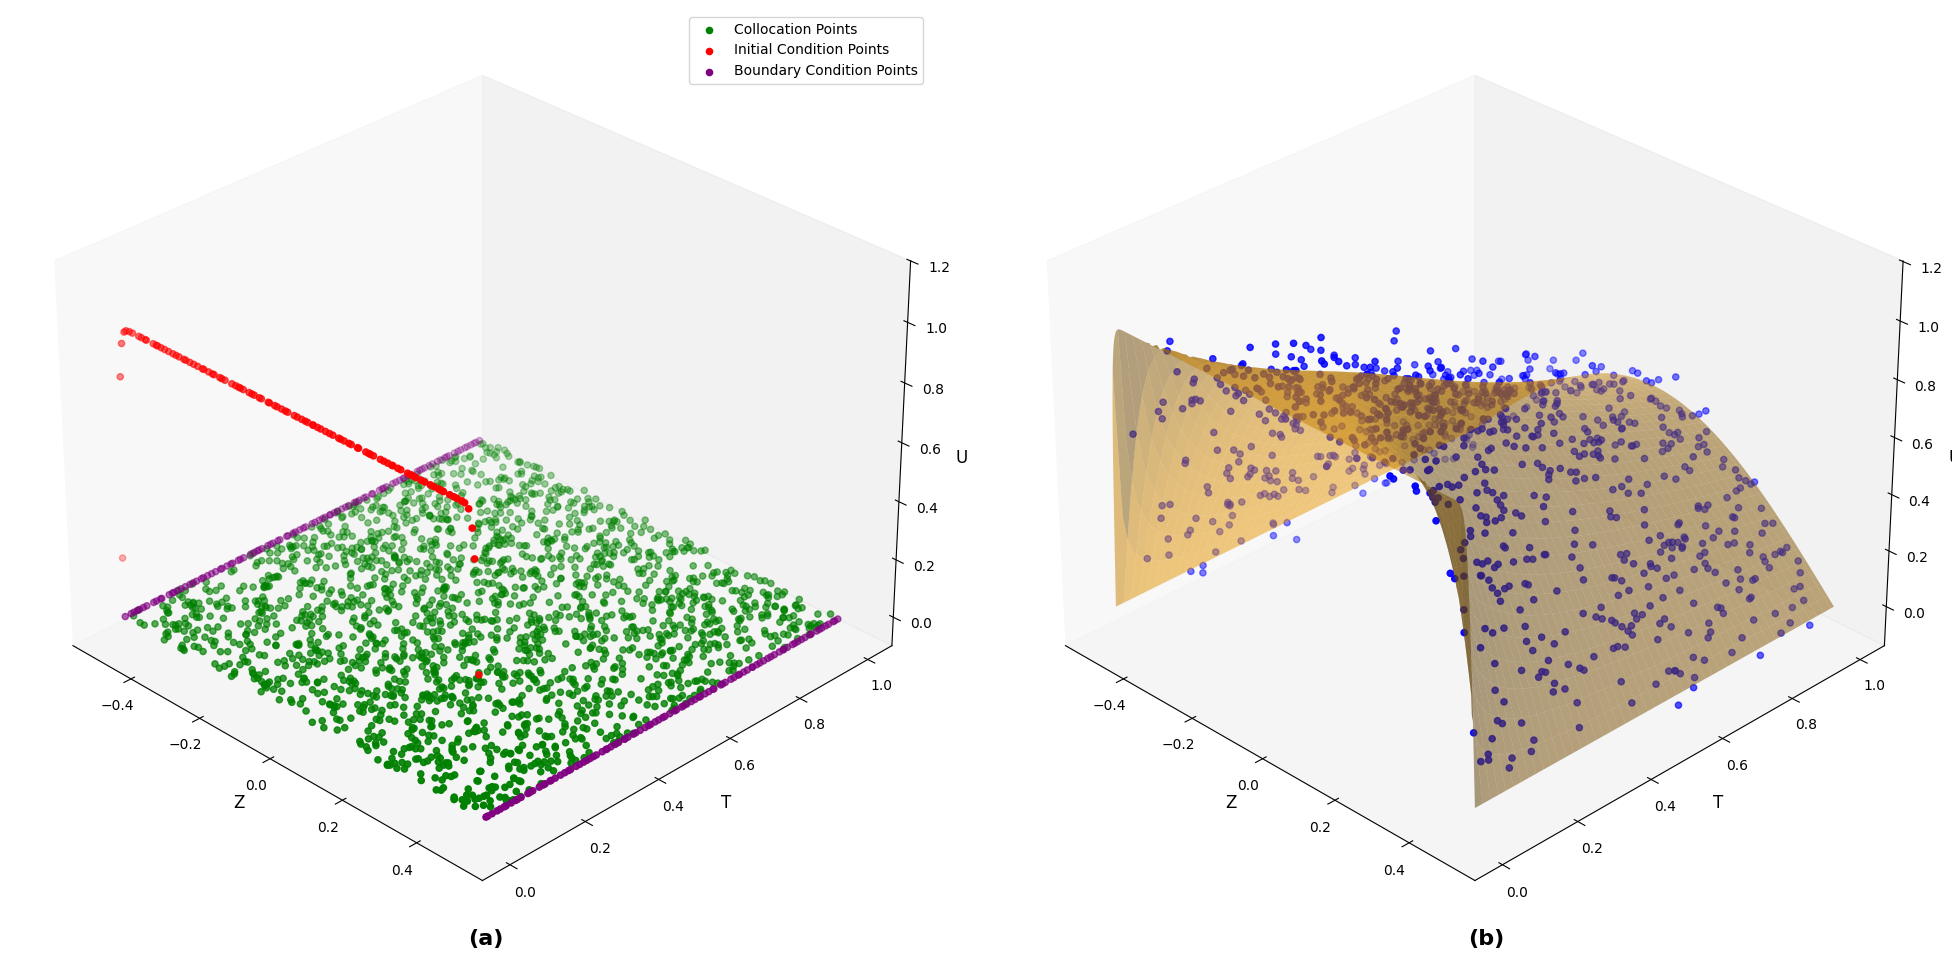

In [9]:
# Create a single figure with subplots for clean and noisy data with titles below
fig = plt.figure(figsize=(20, 10))

# Subplot for clean data
ax1 = fig.add_subplot(121, projection='3d')
#ax1.scatter(zt_data[:, 0], zt_data[:, 1], u_data[:, 0], c='blue', label='Clean Data Points')
# Plot collocation points
ax1.scatter(
    zt_colloc[:, 0].detach().numpy(), zt_colloc[:, 1].detach().numpy(), np.zeros(len(zt_colloc)),
    c='green', label='Collocation Points'
)

ax1.scatter(
    zt_ic[:, 0].detach().numpy(), zt_ic[:, 1].detach().numpy(), u_ic[:, 0].detach().numpy(),
    c='red', label='Initial Condition Points'
)

# Plot boundary condition points
ax1.scatter(
    zt_bc[:, 0].detach().numpy(), zt_bc[:, 1].detach().numpy(), np.zeros(len(zt_bc)),
    c='purple', label='Boundary Condition Points'
)

#ax1.plot_surface(Z, T, U, alpha=0.5, color='orange')
ax1.view_init(30, -45)
ax1.set_xlabel('Z', fontsize=12)
ax1.set_ylabel('T', fontsize=12)
ax1.set_zlabel('U', fontsize=12)
ax1.set_zlim(-0.1, 1.2)
ax1.legend()
ax1.grid(False)

# Subplot for noisy data
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(zt_data_noisy[:, 0], zt_data_noisy[:, 1], u_data_noisy[:, 0], c='blue', label='Noisy Data Points')
ax2.plot_surface(Z, T, U, alpha=0.5, color='orange')
ax2.view_init(30, -45)
ax2.set_xlabel('Z', fontsize=12)
ax2.set_ylabel('T', fontsize=12)
ax2.set_zlabel('U', fontsize=12)
ax2.grid(False)

# Add titles below the subplots with bold font
fig.text(0.26, 0.05, '(a)', ha='center', fontsize=16, fontweight='bold')
fig.text(0.76, 0.05, '(b)', ha='center', fontsize=16, fontweight='bold')

# Adjust layout for clarity
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom for titles
plt.show()

#save the figure   
fig.savefig('data.png', bbox_inches='tight')


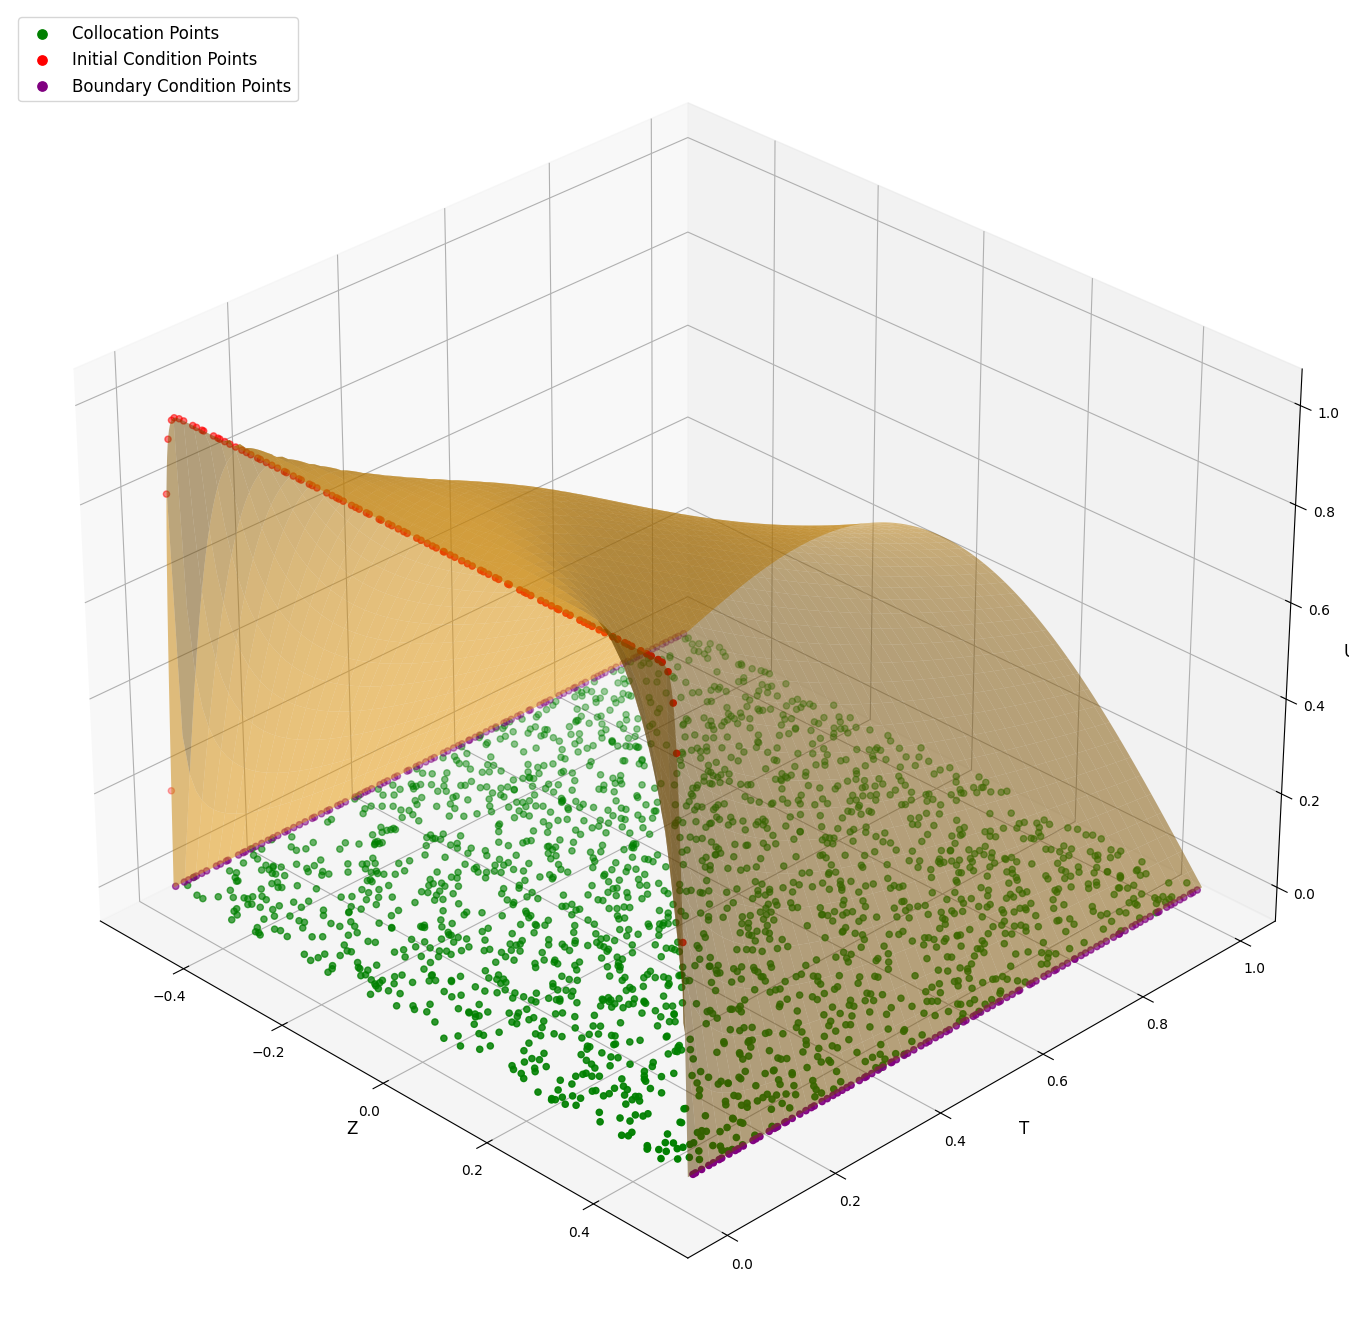

In [10]:


# Redefine the original plot with this example data
fig = plt.figure(figsize=(16, 15))
ax = fig.add_subplot(111, projection='3d')


# Plot collocation points
scatter_colloc = ax.scatter(
    zt_colloc[:, 0].detach().numpy(), zt_colloc[:, 1].detach().numpy(), np.zeros(len(zt_colloc)),
    c='green', label='Collocation Points', s=20
)

# Plot initial condition points
scatter_ic = ax.scatter(
    zt_ic[:, 0].detach().numpy(), zt_ic[:, 1].detach().numpy(), u_ic[:, 0].detach().numpy(),
    c='red', label='Initial Condition Points', s=20
)

# Plot boundary condition points
scatter_bc = ax.scatter(
    zt_bc[:, 0].detach().numpy(), zt_bc[:, 1].detach().numpy(), np.zeros(len(zt_bc)),
    c='purple', label='Boundary Condition Points', s=20
)

# Plot analytical solution
surface = ax.plot_surface(
    Z, T, U, alpha=0.5, color='orange'
)

# Set plot properties
ax.view_init(30, -45)
ax.set_xlabel('Z', fontsize=12)
ax.set_ylabel('T', fontsize=12)
ax.set_zlabel('U', fontsize=12)

# Add legend
ax.legend(loc='upper left', fontsize=12, markerscale=1.5)

#make the top margin smaller

plt.subplots_adjust()


# Show plot
plt.tight_layout(rect = [0.05,0.05,1,0.95])
plt.show()


In [11]:
print(zt_colloc.shape)
print(zt_bc.shape)
print(zt_ic.shape)
print(zt_data.shape)
print(zt_test.shape)
print(u_data.shape)
print(u_ic.shape)
print(U.shape)


torch.Size([2000, 2])
torch.Size([200, 2])
torch.Size([100, 2])
torch.Size([1000, 2])
torch.Size([50000, 2])
torch.Size([1000, 1])
torch.Size([100, 1])
(100, 500)


In [12]:
l_b = torch.tensor([Z.min(), T.min()]).float()
u_b = torch.tensor([Z.max(), T.max()]).float()

print(f'Lower bound: {l_b}, Upper bound: {u_b}')

Lower bound: tensor([-0.5000,  0.0010]), Upper bound: tensor([0.5000, 1.0000])


# Training the network

epoch = 0, training loss = 8.26373,  lr = 0.001, cv = 0.149000
Loss fractions: phys loss: 0.007, data loss: 0.316, bc loss: 0.131, ic loss: 0.546


<Figure size 640x480 with 0 Axes>

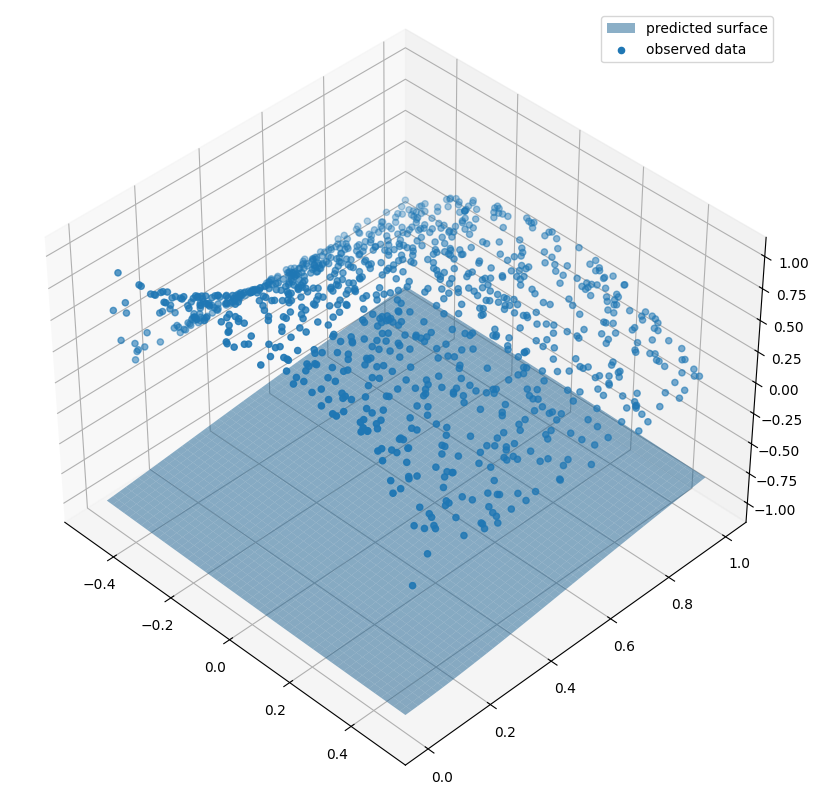

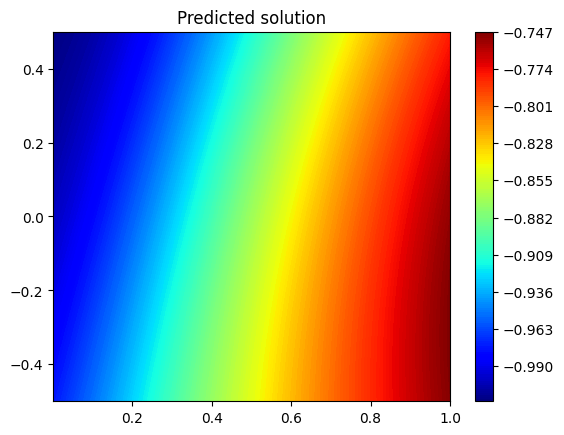

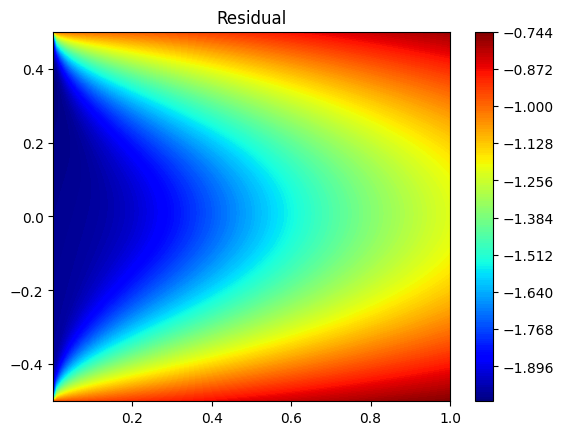

epoch = 1000, training loss = 0.03181,  lr = 0.001, cv = 0.096080
Loss fractions: phys loss: 0.141, data loss: 0.117, bc loss: 0.325, ic loss: 0.417
epoch = 2000, training loss = 0.01493,  lr = 0.001, cv = 0.099024
Loss fractions: phys loss: 0.119, data loss: 0.190, bc loss: 0.287, ic loss: 0.405
epoch = 3000, training loss = 0.00920,  lr = 0.001, cv = 0.096566
Loss fractions: phys loss: 0.178, data loss: 0.314, bc loss: 0.199, ic loss: 0.309
epoch = 4000, training loss = 0.00574,  lr = 0.001, cv = 0.096947
Loss fractions: phys loss: 0.135, data loss: 0.442, bc loss: 0.095, ic loss: 0.328
epoch = 5000, training loss = 0.00407,  lr = 0.001, cv = 0.097854
Loss fractions: phys loss: 0.057, data loss: 0.613, bc loss: 0.045, ic loss: 0.285


<Figure size 640x480 with 0 Axes>

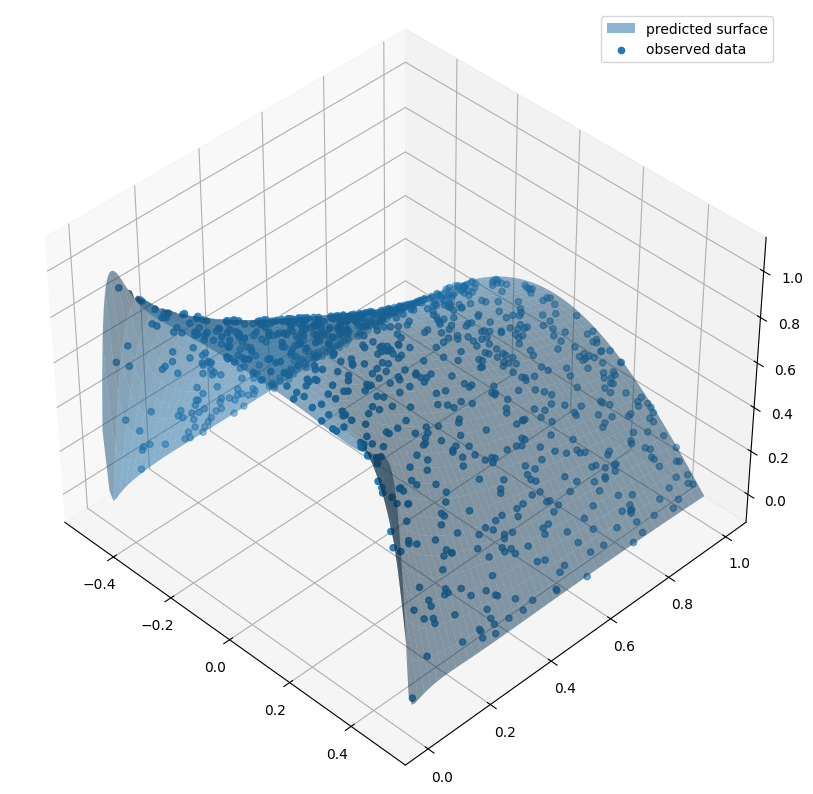

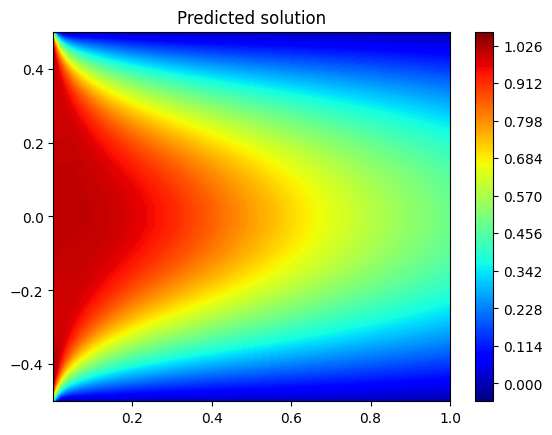

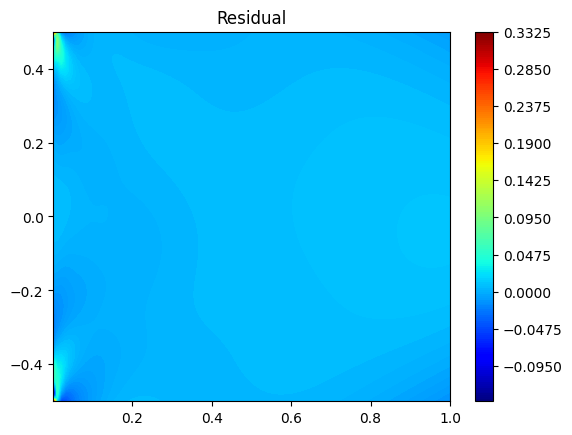

epoch = 6000, training loss = 0.00453,  lr = 0.001, cv = 0.098249
Loss fractions: phys loss: 0.219, data loss: 0.565, bc loss: 0.040, ic loss: 0.176
epoch = 7000, training loss = 0.00379,  lr = 0.001, cv = 0.098439
Loss fractions: phys loss: 0.175, data loss: 0.666, bc loss: 0.026, ic loss: 0.134
epoch = 8000, training loss = 0.00368,  lr = 0.001, cv = 0.098632
Loss fractions: phys loss: 0.190, data loss: 0.692, bc loss: 0.023, ic loss: 0.095
epoch = 9000, training loss = 0.00325,  lr = 0.001, cv = 0.098798
Loss fractions: phys loss: 0.135, data loss: 0.781, bc loss: 0.028, ic loss: 0.057
epoch = 10000, training loss = 0.00276,  lr = 0.001, cv = 0.099067
Loss fractions: phys loss: 0.042, data loss: 0.906, bc loss: 0.014, ic loss: 0.037


<Figure size 640x480 with 0 Axes>

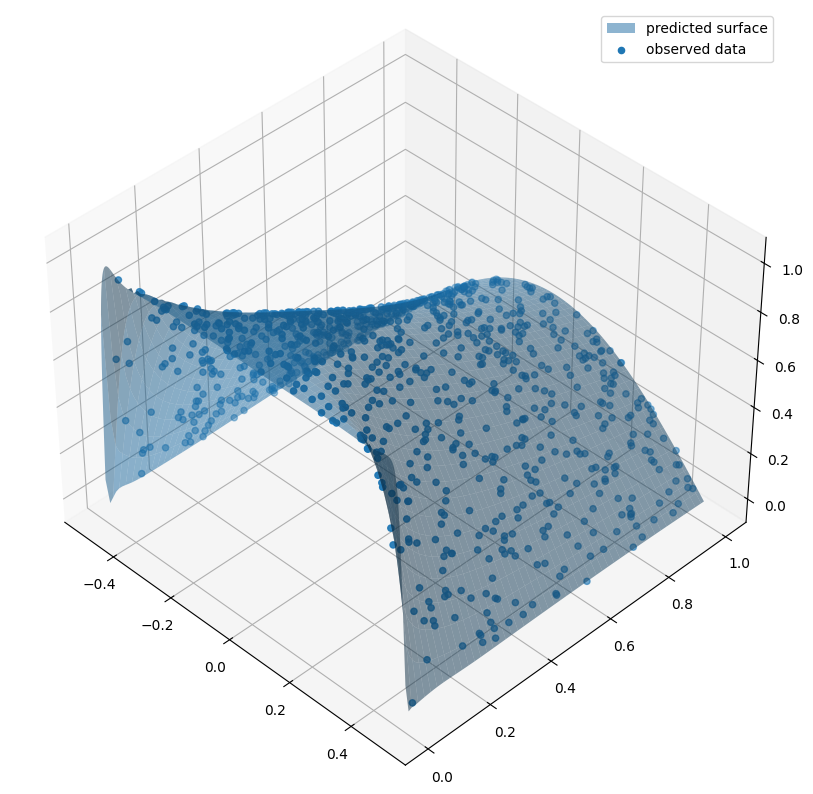

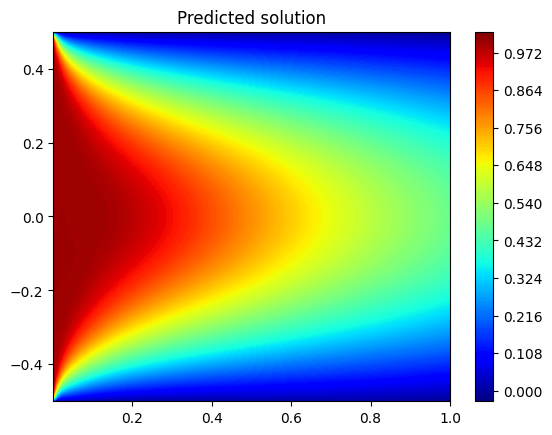

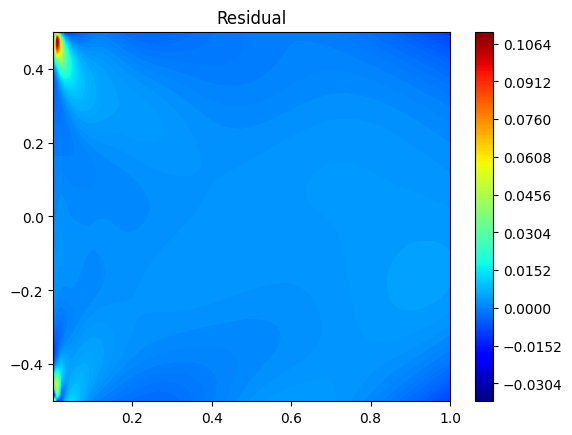

epoch = 11000, training loss = 0.00307,  lr = 0.001, cv = 0.099180
Loss fractions: phys loss: 0.124, data loss: 0.826, bc loss: 0.035, ic loss: 0.015
epoch = 12000, training loss = 0.00296,  lr = 0.001, cv = 0.099313
Loss fractions: phys loss: 0.109, data loss: 0.856, bc loss: 0.021, ic loss: 0.014
epoch = 13000, training loss = 0.00291,  lr = 0.001, cv = 0.099252
Loss fractions: phys loss: 0.119, data loss: 0.861, bc loss: 0.013, ic loss: 0.007
epoch = 14000, training loss = 0.00284,  lr = 0.001, cv = 0.099329
Loss fractions: phys loss: 0.076, data loss: 0.889, bc loss: 0.021, ic loss: 0.013
epoch = 15000, training loss = 0.00258,  lr = 0.001, cv = 0.099308
Loss fractions: phys loss: 0.025, data loss: 0.967, bc loss: 0.005, ic loss: 0.003


<Figure size 640x480 with 0 Axes>

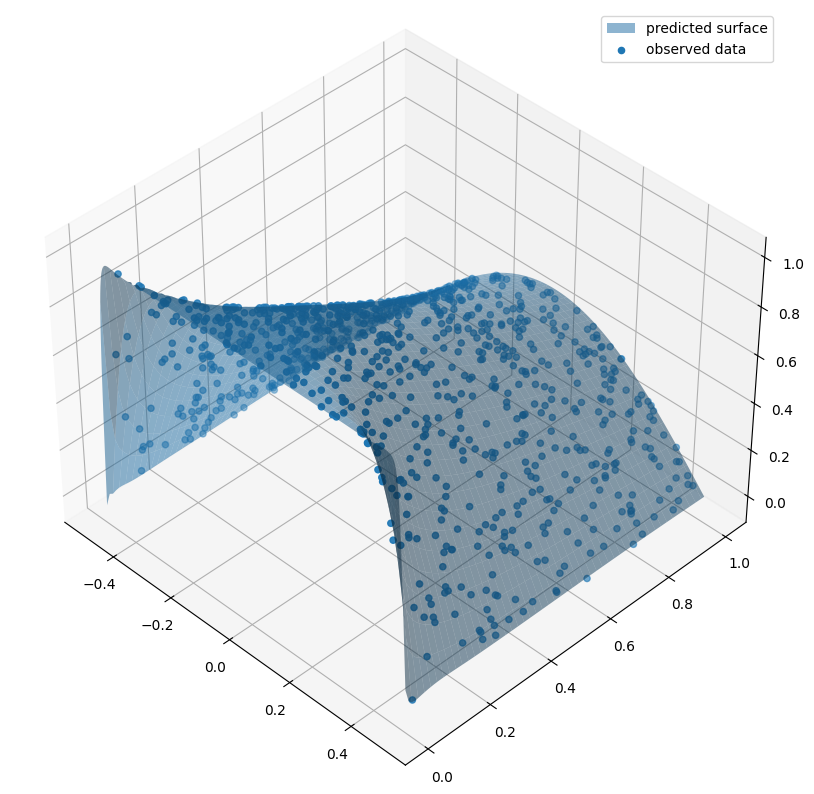

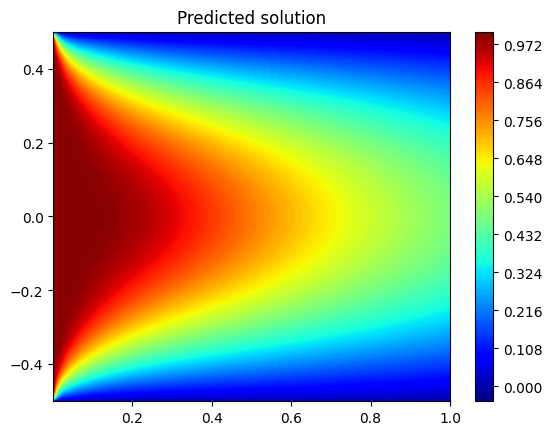

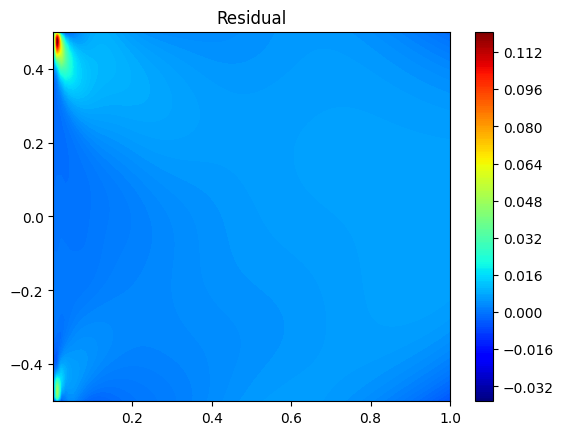

epoch = 16000, training loss = 0.00258,  lr = 0.001, cv = 0.099265
Loss fractions: phys loss: 0.023, data loss: 0.966, bc loss: 0.006, ic loss: 0.005
epoch = 17000, training loss = 0.00278,  lr = 0.001, cv = 0.099304
Loss fractions: phys loss: 0.086, data loss: 0.904, bc loss: 0.008, ic loss: 0.002
epoch = 18000, training loss = 0.00336,  lr = 0.001, cv = 0.099237
Loss fractions: phys loss: 0.193, data loss: 0.762, bc loss: 0.044, ic loss: 0.002
epoch = 19000, training loss = 0.00319,  lr = 0.001, cv = 0.099324
Loss fractions: phys loss: 0.127, data loss: 0.815, bc loss: 0.045, ic loss: 0.013
epoch = 20000, training loss = 0.00269,  lr = 0.001, cv = 0.099251
Loss fractions: phys loss: 0.056, data loss: 0.934, bc loss: 0.009, ic loss: 0.001


<Figure size 640x480 with 0 Axes>

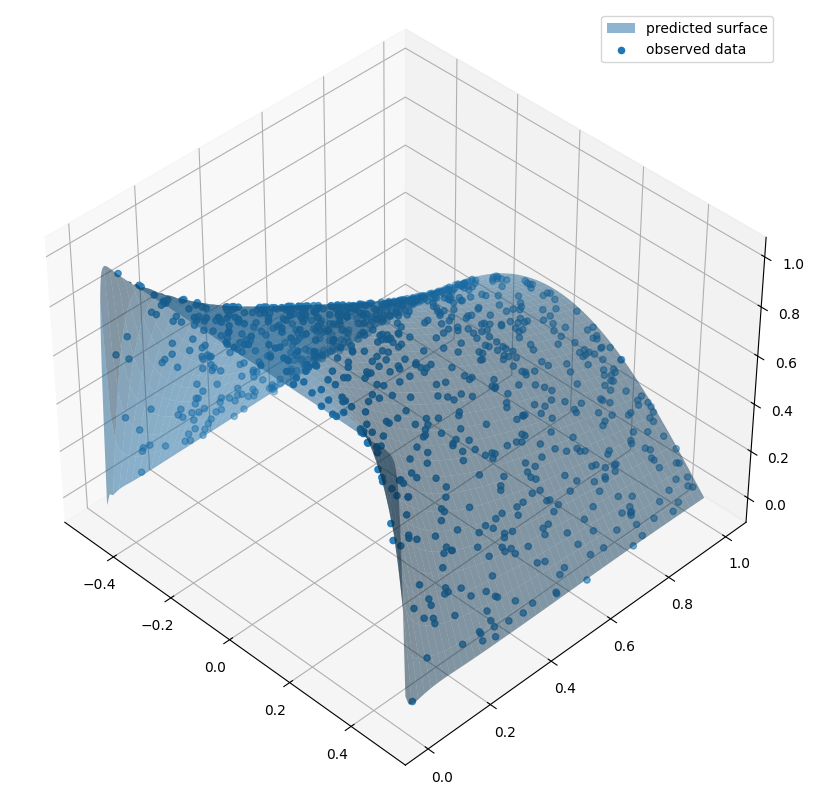

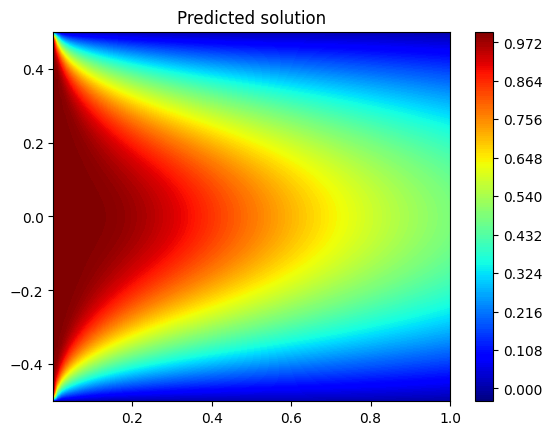

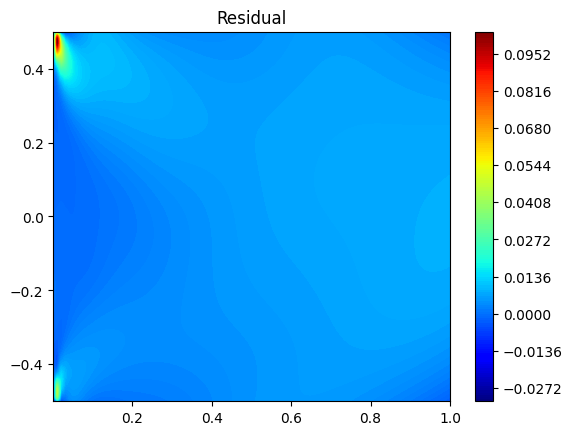

epoch = 21000, training loss = 0.00261,  lr = 0.001, cv = 0.099245
Loss fractions: phys loss: 0.020, data loss: 0.954, bc loss: 0.007, ic loss: 0.018
epoch = 22000, training loss = 0.00298,  lr = 0.001, cv = 0.099305
Loss fractions: phys loss: 0.134, data loss: 0.851, bc loss: 0.014, ic loss: 0.002
epoch = 23000, training loss = 0.00261,  lr = 0.001, cv = 0.099273
Loss fractions: phys loss: 0.023, data loss: 0.956, bc loss: 0.008, ic loss: 0.013
epoch = 24000, training loss = 0.00254,  lr = 0.001, cv = 0.099234
Loss fractions: phys loss: 0.012, data loss: 0.980, bc loss: 0.005, ic loss: 0.003
epoch = 25000, training loss = 0.00259,  lr = 0.001, cv = 0.099260
Loss fractions: phys loss: 0.030, data loss: 0.963, bc loss: 0.003, ic loss: 0.004


<Figure size 640x480 with 0 Axes>

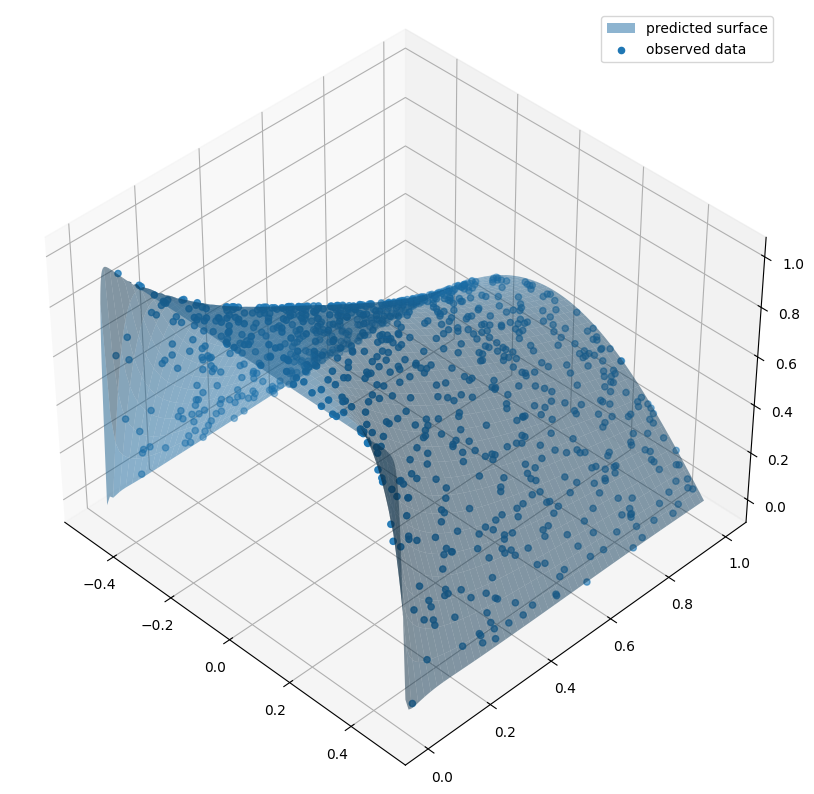

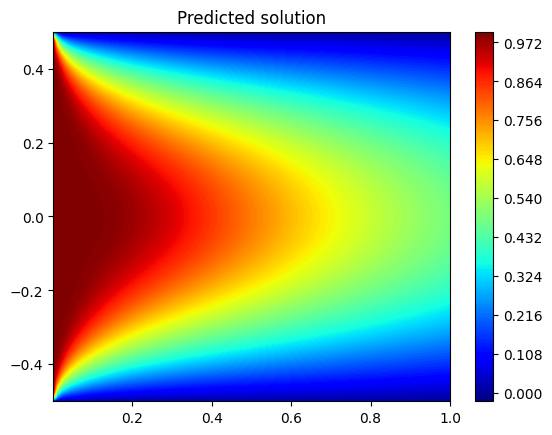

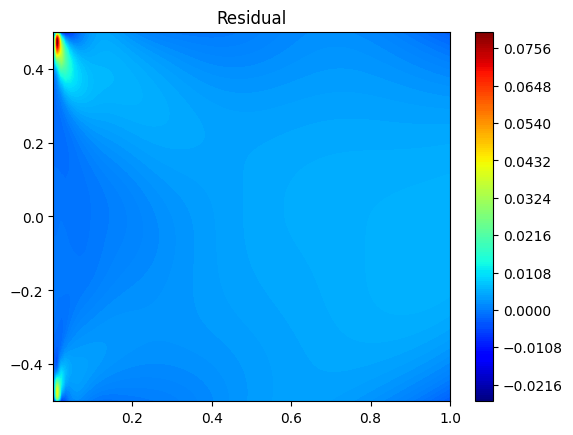

epoch = 26000, training loss = 0.00252,  lr = 0.001, cv = 0.099250
Loss fractions: phys loss: 0.009, data loss: 0.987, bc loss: 0.003, ic loss: 0.001
epoch = 27000, training loss = 0.00272,  lr = 0.001, cv = 0.099223
Loss fractions: phys loss: 0.039, data loss: 0.923, bc loss: 0.018, ic loss: 0.020
epoch = 28000, training loss = 0.00265,  lr = 0.001, cv = 0.099198
Loss fractions: phys loss: 0.015, data loss: 0.946, bc loss: 0.025, ic loss: 0.014
epoch = 29000, training loss = 0.00266,  lr = 0.001, cv = 0.099182
Loss fractions: phys loss: 0.053, data loss: 0.936, bc loss: 0.006, ic loss: 0.005
epoch = 30000, training loss = 0.00288,  lr = 0.001, cv = 0.099165
Loss fractions: phys loss: 0.068, data loss: 0.879, bc loss: 0.044, ic loss: 0.009


<Figure size 640x480 with 0 Axes>

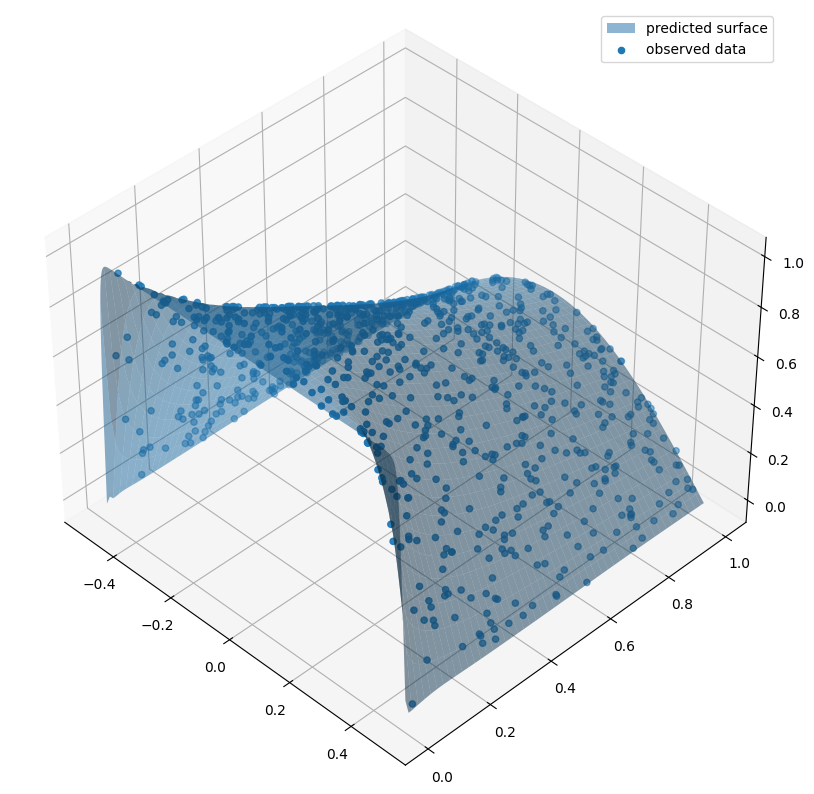

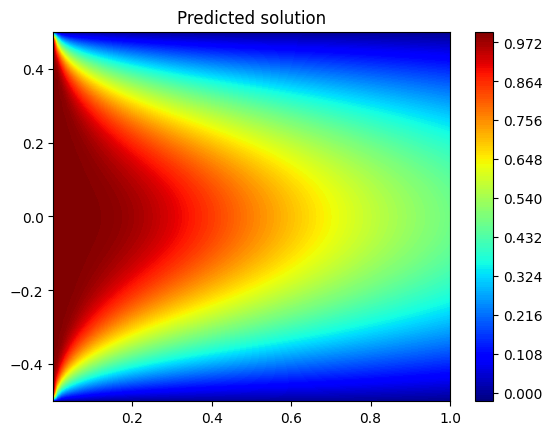

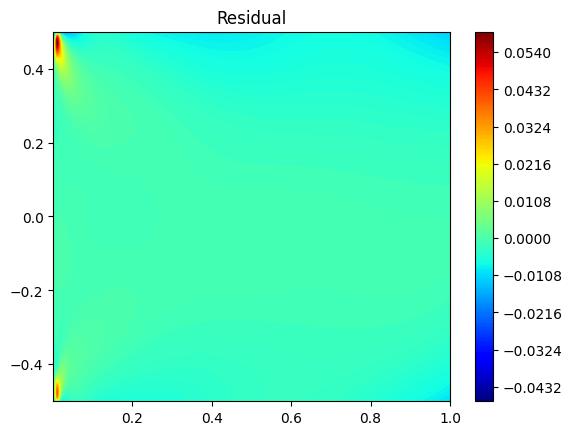

In [13]:
torch.manual_seed(seed)
np.random.seed(seed)


pinn = FCN(2, 1, 20, 8)

epochs = 30001
lambda_PDE = 1e-0
lambda_data = 1e0
lambda_bc = 1e-0
lambda_ic = 1e0
loss_PDE_history = []
loss_data_history = []
loss_bc_history = []
loss_ic_history = []
loss_history = []
best_loss = float('inf')
best_model_state = None

cv = torch.nn.Parameter(0.15*torch.ones(1, requires_grad=True)).float()
cvs = []


optimizer = torch.optim.Adam(list(pinn.parameters()) + [cv] , lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4000, 8000, 12000, 16000, 22000, 28000] , gamma=0.5)


# Training loop
for i in range(epochs):
    optimizer.zero_grad()

    # Physics loss
    u = pinn(zt_colloc)

  
    u_z = torch.autograd.grad(u, z_colloc, torch.ones_like(u), create_graph=True, retain_graph=True)[0].view(-1, 1)
    u_zz = torch.autograd.grad(u_z, z_colloc, torch.ones_like(u_z), create_graph=True)[0].view(-1, 1)
    u_t = torch.autograd.grad(u, t_colloc, torch.ones_like(u), create_graph=True)[0].view(-1, 1)
    
    loss_PDE = torch.mean((u_t - cv * u_zz)**2)
    
    # Data loss
    u_data_pred = pinn(zt_data_noisy)
    loss_data = torch.mean((u_data_pred - u_data_noisy)**2)

    # Boundary condition loss
    u_bc_pred = pinn(zt_bc)
    loss_bc = torch.mean((u_bc_pred-u_bc)**2)

    #Initial condition loss
    u_ic_pred = pinn(zt_ic)
    loss_ic = torch.mean((u_ic_pred-u_ic)**2)
    
    
    

    # Backpropagation
    loss = lambda_PDE*loss_PDE + lambda_data*loss_data + lambda_bc*loss_bc + lambda_ic*loss_ic 

    # Save best model
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_state = pinn.state_dict()
    
    
    loss_history.append(loss.item())
    loss_PDE_history.append(loss_PDE.item())
    loss_data_history.append(loss_data.item())
    loss_bc_history.append(loss_bc.item())
    loss_ic_history.append(loss_ic.item())
    loss.backward()
    optimizer.step()
    #scheduler.step()
    


   
    cvs.append(cv.item())   

    if i % 1000 == 0:
        print(f'epoch = {i}, training loss = {loss.item():.5f},  lr = {optimizer.param_groups[0]["lr"]}, cv = {cv.item():.6f}')     #validation loss = {val_loss.item():.5f},
        print(f'Loss fractions: phys loss: {lambda_PDE*loss_PDE/loss:.3f}, data loss: {(lambda_data*loss_data/loss):.3f}, bc loss: {(lambda_bc*loss_bc/loss):.3f}, ic loss: {(lambda_ic*loss_ic/loss):.3f}')

    if i % 5000 == 0:
        u_pred = pinn(torch.cat([Z_test.unsqueeze(2), T_test.unsqueeze(2)], dim=2).view(-1, 2)).detach().numpy().reshape(Z.shape)
        fig = plt.figure()
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(Z, T, u_pred, alpha=0.5, label = 'predicted surface')
        ax.scatter(zt_data[:,0].detach().numpy(), zt_data[:,1].detach().numpy(), u_data.detach().numpy().squeeze(), label = 'observed data')
        ax.view_init(elev=40, azim=-45)
        plt.legend()
        plt.show()


        # plot of predicted solution
        plt.contourf(T, Z, u_pred, cmap='jet', levels=200)
        plt.title('Predicted solution')
        plt.colorbar()
        plt.show()

        # plot of residual
        plt.contourf(T, Z, u_pred - U, cmap='jet', levels=200)
        plt.title('Residual')
        plt.colorbar()
        plt.show()


    torch.save(best_model_state, "best_pinn_model.pth")
    

    # Load the best model for evaluation
    pinn.load_state_dict(best_model_state)


# Plotting evolution of consolidsation parameter and training loss

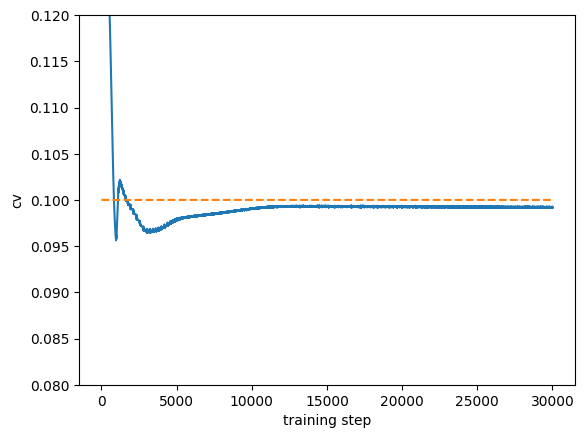

C:\Users\jolu2\AppData\Local\Temp\ipykernel_29156\2338176331.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 0.5])


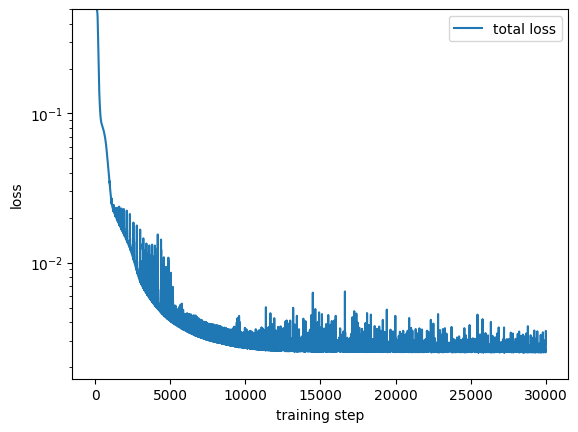

C:\Users\jolu2\AppData\Local\Temp\ipykernel_29156\2338176331.py:31: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0, 0.1])


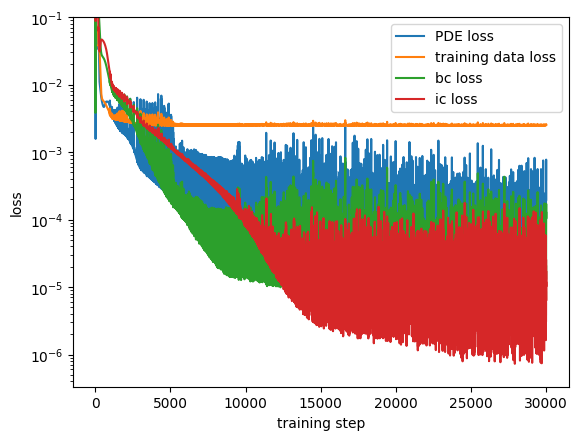

In [14]:

plt.figure()
plt.plot(cvs, label = 'predicted mu')
plt.plot([cv_obs]*len(cvs), linestyle = '--', label = 'true value')
plt.ylim([0.08, 0.12])
plt.xlabel('training step')
plt.ylabel('cv')
plt.show()



plt.figure()
plt.plot(loss_history, label = 'total loss')
plt.xlabel('training step')
plt.ylabel('loss')
plt.yscale('log')
plt.ylim([0, 0.5])
plt.legend()
plt.show()

plt.figure()
plt.plot(loss_PDE_history, label = 'PDE loss')
#plt.plot(loss_gradient_history, label = 'gradient loss')
plt.plot(loss_data_history, label = 'training data loss')
plt.plot(loss_bc_history, label = 'bc loss')
plt.plot(loss_ic_history, label = 'ic loss')


plt.xlabel('training step')
plt.ylabel('loss')
plt.yscale('log')
plt.ylim([0, 0.1])
plt.legend()
plt.show()



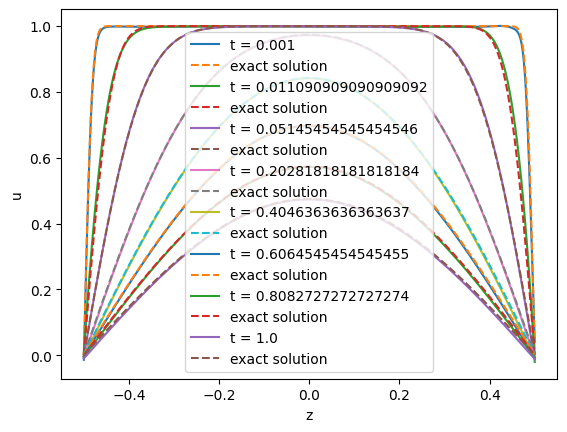

In [15]:
#plot u vs z predicted against exact solution at 10 different timesteps
timesteps = [0, 1, 5, 20, 40, 60, 80, 99]
plt.figure()
for i in timesteps:
    plt.plot(z, u_pred[i, :], label = f't = {T[i, 1]}')
    plt.plot(z, U[i, :], linestyle = '--', label = 'exact solution')
plt.xlabel('z')
plt.ylabel('u')
plt.legend()
plt.show()



In [16]:
pinn.load_state_dict(best_model_state)

# Generate predictions for the best model
u_pred_best = pinn(torch.cat([Z_test.unsqueeze(2), T_test.unsqueeze(2)], dim=2).view(-1, 2)).detach().numpy().reshape(Z.shape)
residual = u_pred_best - U
#residual2 = u_pred_best2 - U

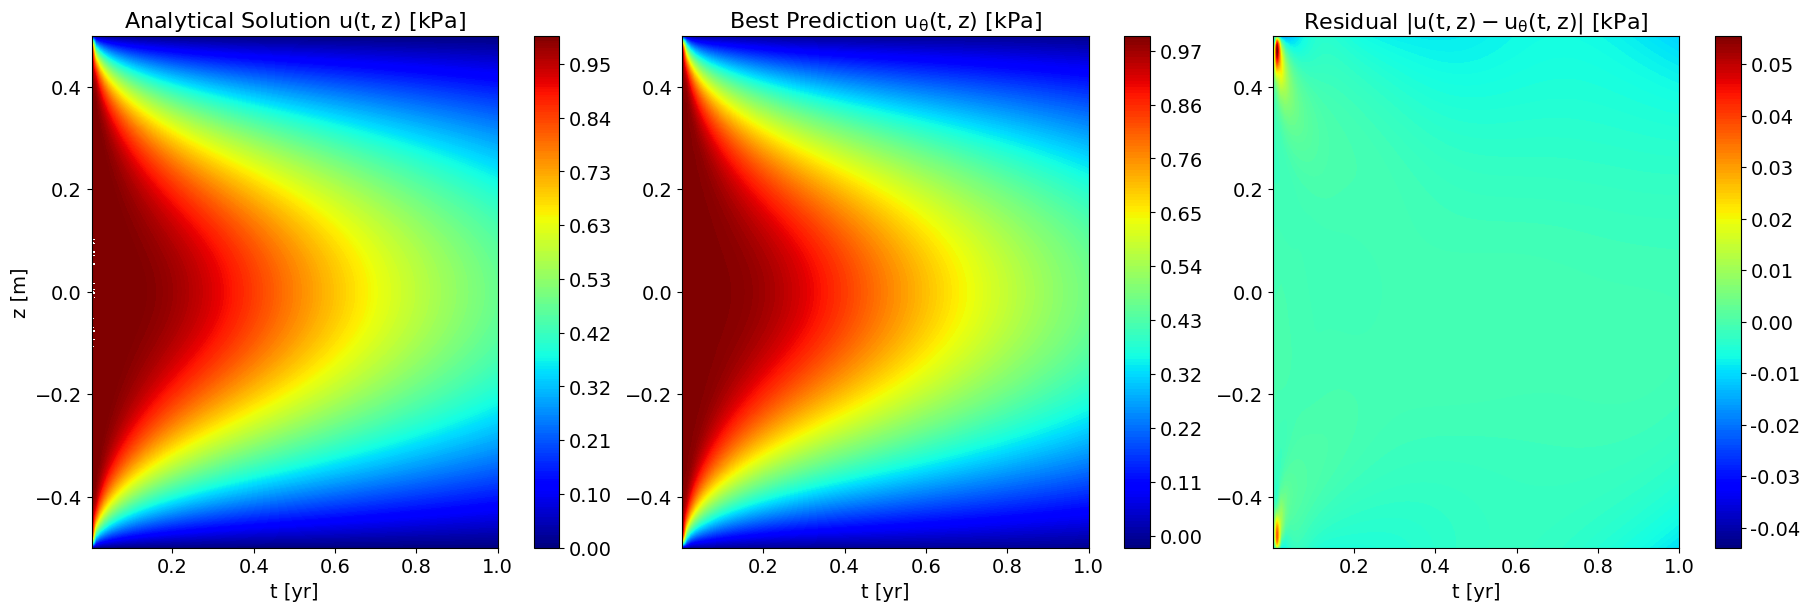

In [17]:
# Plot analytical solution, best prediction, and residual in 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Analytical solution
cs1 = axs[0].contourf(T, Z, U, cmap='jet', levels=200)
axs[0].set_title(r'Analytical Solution $\mathrm{u(t,z)}$ [kPa]', fontsize=16)  # Larger title
axs[0].set_xlabel('t [yr]', fontsize=14)  # Larger x-axis label
axs[0].set_ylabel('z [m]', fontsize=14)  # Larger y-axis label
axs[0].tick_params(labelsize=14)  # Larger tick labels for axis
cbar1 = fig.colorbar(cs1, ax=axs[0], format='%.2f')
cbar1.ax.tick_params(labelsize=14)  # Adjust colorbar ticks

# Best prediction
cs2 = axs[1].contourf(T, Z, u_pred_best, cmap='jet', levels=200)
axs[1].set_title(r'Best Prediction $\mathrm{u_\theta(t,z)}$ [kPa]', fontsize=16)
axs[1].set_xlabel('t [yr]', fontsize=14)
axs[1].tick_params(labelsize=14)  # Larger tick labels for axis
cbar2 = fig.colorbar(cs2, ax=axs[1], format='%.2f')
cbar2.ax.tick_params(labelsize=14)

# Residual
cs3 = axs[2].contourf(T, Z, residual, cmap='jet', levels=200)
axs[2].set_title(r'Residual $\mathrm{|u(t,z) - u_\theta(t,z)|}$ [kPa]', fontsize=16)
axs[2].set_xlabel('t [yr]', fontsize=14)
axs[2].tick_params(labelsize=14)  # Larger tick labels for axis
cbar3 = fig.colorbar(cs3, ax=axs[2], format='%.2f')
cbar3.ax.tick_params(labelsize=14)

# Save and show the plot
plt.savefig("PINN_results_noisy.png", dpi=300)
plt.show()

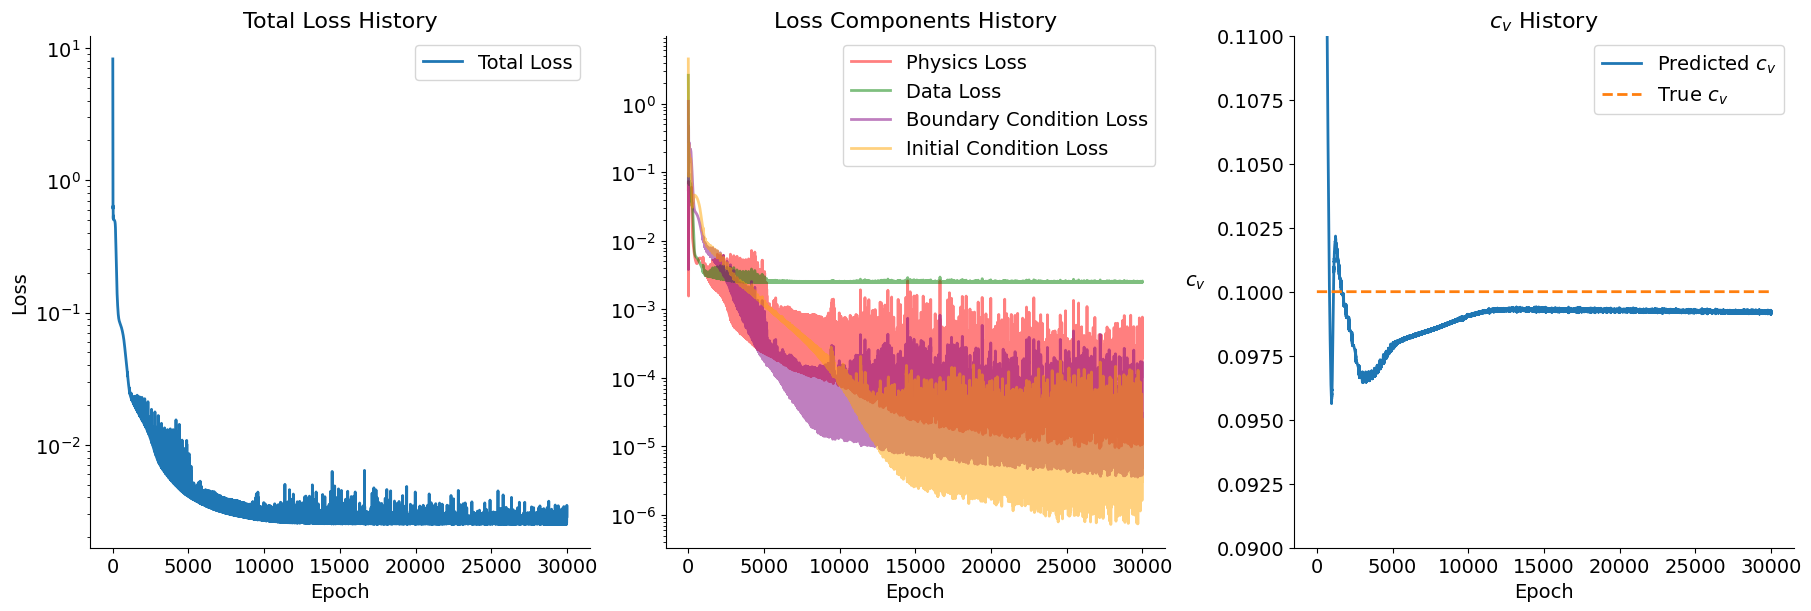

In [18]:
# Create a publication-ready plot with log scale
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

# Total loss history with log scale
axs2[0].plot(loss_history, label='Total Loss', linewidth=2)
axs2[0].set_title('Total Loss History', fontsize=16)
axs2[0].set_xlabel('Epoch', fontsize=14)
axs2[0].set_ylabel('Loss', fontsize=14)
axs2[0].set_yscale('log')
axs2[0].tick_params(labelsize=14)
axs2[0].legend(fontsize=14)


# Loss fractions history with log scale
axs2[1].plot(loss_PDE_history, label='Physics Loss', linewidth=2, color='red', alpha=0.5)
axs2[1].plot(loss_data_history, label='Data Loss', linewidth=2, color='green', alpha=0.5)
axs2[1].plot( loss_bc_history, label='Boundary Condition Loss', linewidth=2, color='purple', alpha=0.5)
axs2[1].plot(loss_ic_history, label='Initial Condition Loss', linewidth=2, color='orange', alpha=0.5)
axs2[1].set_title('Loss Components History', fontsize=16)
axs2[1].set_xlabel('Epoch', fontsize=14)
axs2[1].set_yscale('log')
axs2[1].tick_params(labelsize=14)
axs2[1].legend(fontsize=14)

# CV history
axs2[2].plot(cvs, label='Predicted $c_v$', linewidth=2)
axs2[2].plot([cv_obs]*len(cvs), linestyle='--', label='True $c_v$', linewidth=2)
axs2[2].set_title('$c_v$ History', fontsize=16)
axs2[2].set_xlabel('Epoch', fontsize=14)
axs2[2].set_ylabel('$c_v$', fontsize=14, rotation=0, labelpad=15)
axs2[2].set_ylim(0.09, 0.11)
axs2[2].tick_params(labelsize=14)
axs2[2].legend(fontsize=14)




# Aesthetic improvements
for ax in axs2:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Save the plot as an image file
plt.savefig('PINN_losses_noise.png', dpi=300)
plt.show()
